In [311]:
import numpy as np
from numba import njit, prange

N = 2

@njit
def make_grid(n):
    grid = np.zeros((n, n), dtype=np.int8)
    return grid

@njit
def add_sand(grid, x, y):
    grid[x, y] += 1

@njit
def add_sand_random(grid):
    n = grid.shape[0]
    x : int = np.random.randint(0, n)
    y : int = np.random.randint(0, n)
    add_sand(grid, x, y)


@njit
def get_nb(nb):
    if nb == 0:
        return (1, 0)
    elif nb == 1:
        return (-1, 0)
    elif nb == 2:
        return (0, 1)
    elif nb == 3:
        return (0, -1)

@njit(parallel=False)
def propagate(grid) -> tuple[int, int]:
    size = grid.shape[0]
    ng = np.zeros_like(grid, dtype=np.int8)


    for x in prange(size):
        for y in range(size):
            if not grid[x, y] >= N:
                continue

            ng[x, y] -= N
            for _ in range(N):
                dx, dy = get_nb(np.random.randint(0, 4))

                if (x + dx) >= 0 and (x + dx) < size and (y + dy) >= 0 and (y + dy) < size:
                    ng[x + dx, y + dy] += 1

    
    grid += ng


    # find longest linear dimension
    wh_x, wh_y = np.where(ng > 0)
    # wh_x, wh_y = 0,0

    if len(wh_x) > 0:
        extend_x, extend_y = np.max(wh_x) - np.min(wh_x), np.max(wh_y) - np.min(wh_y)
    else:
        extend_x, extend_y = 0, 0


    return (np.count_nonzero(ng), max([extend_x, extend_y]))

@njit
def topple(grid):
    number = 0
    max_extend = 0
    while True:
        p = propagate(grid)
        extend = p[1]
        p = p[0]
        if extend > max_extend:
            max_extend = extend
        number += p
        if p == 0:
            break

    return number, max_extend


@njit
def step(grid, placing):
    if placing == 'normal':
        add_sand_random(grid)
    else:
        add_sand_edge(grid)
    t = topple(grid)
    return t
    

@njit
def add_sand_edge(grid):
    n = grid.shape[0]
    edge = np.random.randint(0, 4)

    if edge == 0:
        x = 0
        y = np.random.randint(0, n)
    elif edge == 1:
        x = n-1
        y = np.random.randint(0, n)
    elif edge == 2:
        x = np.random.randint(0, n)
        y = 0
    elif edge == 3:
        x = np.random.randint(0, n)
        y = n-1

    add_sand(grid, x, y)

@njit
def run(size, n_steps, placing = 'normal'):
    grid = make_grid(size)
    ns = np.zeros(n_steps)
    extends = np.zeros(n_steps)

    for i in range(n_steps):
        ret = step(grid, placing)
        ns[i] = ret[0]
        extends[i] = ret[1]


    return grid, ns, extends





Implement the above model for a L × L lattice with L = 25 and plot the sequence of avalanches as a function of time. The avalanche size is defined as the number of single-site relaxations until the new relaxed state is reached. Convince yourself when steady state dynamics is reached (this critical attractor is characterized by avalanches that do not anymore increase in size) 2pt. 

In [312]:
size = 25
grid, ns, extends = run(size, 1500)
first_time = np.where(ns/(size*size) > 5)[0][0]


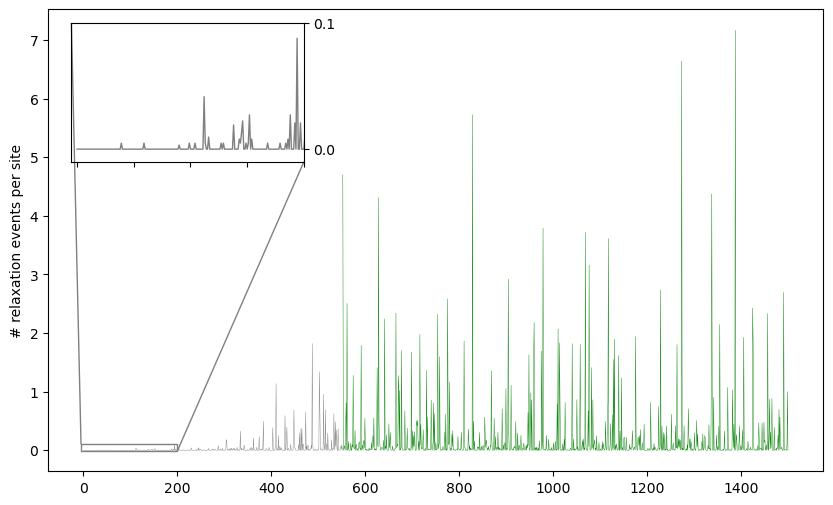

In [313]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import seaborn as sns

fig = plt.figure(figsize=(10, 6))

first_time = np.where(ns/(size*size) > 4)[0][0]

x = np.arange(len(ns))

plt.plot(x[first_time:], ns[first_time:]/(size*size), c = "green", label="after critical time", linewidth=0.3)
plt.plot(x[:first_time], ns[:first_time]/(size*size), c = "grey", label="before critical time", linewidth=0.3)
# plt.yscale("log")

plt.ylabel("# relaxation events per site")
# make inset axis
ax = plt.gca()
axins = ax.inset_axes([0.03, 0.67, 0.3, 0.3])
axins.plot(x[:first_time], ns[:first_time]/(size*size), c = "grey", linewidth=1)
axins.set_xlim(-5, 200)
axins.set_ylim(-0.01, 0.1)
axins.set_xticklabels('')
# draw y ticks on the right side of the inset axes
axins.yaxis.tick_right()
axins.set_yticks([0, 0.1])




# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()


Consider system sizes L = 25, L = 50, L = 100 and L = 200 and simulate each system until a steady state is reached. In steady state, you should extract the size distribution of the avalanches, and estimate the exponent for the size distribution and for the scaling of the avalanche cut off with system size L (dimension of avalanches) 4pt. 

In [339]:
sims = []
for size, n_steps in zip([25, 50, 100, 200], [20000, 25000, 35000, 52000]):

    grid, ns, extends = run(size, n_steps)
    first_time = np.where(ns/(size*size) > 4)[0][0]

    sims.append(ns[first_time:])

In [348]:
# make numpy histograms
hists = []
edges  = []
for sim in sims:
    print(len(sim))
    hist, edge = np.histogram(sim, bins=31, density=True)
    
    
    edges.append(((edge[1:] + edge[:1])/2)[1:])

    hists.append(hist[1:])

19425
23061
28031
23285


2.03670380354592
2.1336488985462405
2.2267711675598334
2.2515636464621314


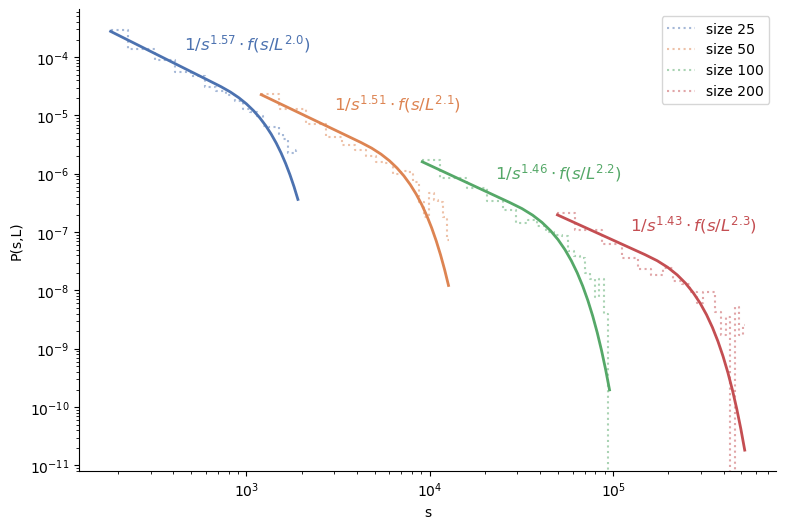

In [369]:
from scipy.optimize import curve_fit
import seaborn as sns

def fit_fun_over(x, tau, cutoff):

    y =  x ** (-tau)

    y[x > cutoff] *= np.exp(-((x[x>cutoff] - cutoff)/cutoff)**2)

    return y


fig = plt.figure(figsize=(9, 6))


Ls = [25, 50, 100, 200]
colors = sns.color_palette("deep", 4)

taus = []
dimensions = []


for i in range(len(sims)):

    x, y = edges[i][:-10], hists[i][:-10]

    fit_fun = lambda x, tau, d: fit_fun_over(x, tau, Ls[i]**d)

    plt.step(x, y,where='mid',color=colors[i],linestyle=':', label=f"size {Ls[i]}", alpha = 0.5)

    popt, pcov = curve_fit(fit_fun, x, y, p0=[1.5, 2.3])
    taus.append(popt[0])
    dimensions.append(popt[1])
    print(popt[1])

    # plt.vlines(Ls[i]**popt[1], 1e-9, 1e-5, color = colors[i])
    plt.plot(x, fit_fun(x, *popt), '-', color=colors[i], linewidth=2)

    # print text with fit parameters
    plt.text(x[3], y[1], "$1/s^{"+ f"{popt[0]:.3}" + "}\cdot f(s/L^{"+ f"{popt[1]:.2}" + "})$", color = colors[i], fontsize=12)



plt.legend()
plt.yscale("log")
plt.xscale("log")
sns.despine()
plt.ylabel("P(s,L)")
plt.xlabel("s")
plt.show()

[2.4330732337520473, 2.318664313905072, 2.3440037372915463, 2.310389770502313]

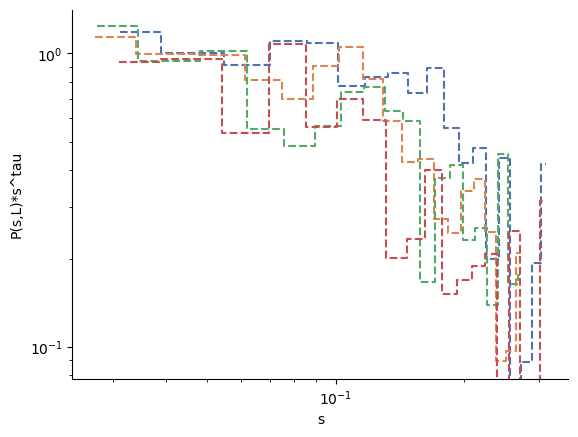

In [269]:
for i in range(len(sims)):
    plt.step(edges[i] / [25, 50, 100, 200][i]**2.8, hists[i]*np.power(edges[i],taus[i]),where='mid',color=colors[i],linestyle='--', label=f"size {[25, 50, 100, 200][i]}", alpha = 1)


plt.yscale("log")
plt.xscale("log")
sns.despine()
plt.ylabel("P(s,L)*s^tau")
plt.xlabel("s")
plt.show()


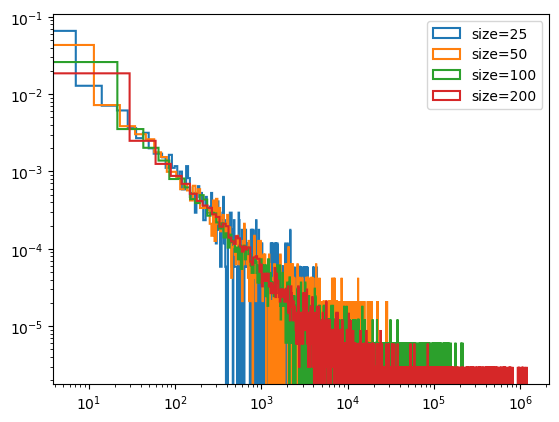

In [33]:
# get first occurence of 


for ns, size in zip(sims, [25, 50, 100, 200]):
    first_time = np.where(ns/(size*size) > 4)[0][0]

    plt.hist(ns[first_time:], bins=size*size, density=True, histtype = "step", label=f"size={size}", linewidth=1.5)

plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.show()

3. For a big lattice, then plot the size of avalanches (in number of relaxation events) as a function of the largest linear dimension of each avalanche (longest extension of avalanche along either the x-axis or y-axis). Deduce the dimension of the avalanche 2pt. 

In [370]:
size = 400
grid, ns, extends = run(size, 120000)
first_time = np.where(ns/(size*size) > 4)[0][0]


[2.58511244]


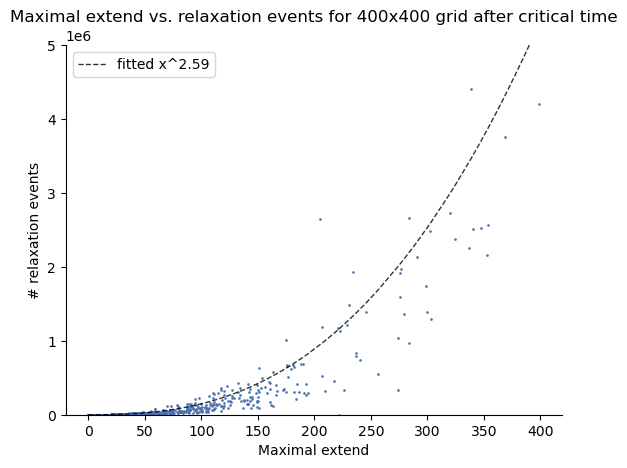

In [386]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.scatter(extends[first_time:], ns[first_time:], s=0.8, color = colors[0])

dimension_func = lambda x, b: np.power(x, b)

popt, pcov = curve_fit(dimension_func, extends[first_time:], ns[first_time:])
print(popt)

srt = np.argsort(extends[first_time:])
x = extends[first_time:][srt]
y = dimension_func(extends[first_time:], *popt)[srt]
plt.plot(x, y, '--', linewidth=1, c="black", label=f"fitted x^{popt[0]:.3}", alpha=0.8)
plt.ylim(0, 5e6)
plt.legend()
sns.despine()

plt.xlabel("Maximal extend")
plt.ylabel("# relaxation events")

plt.title("Maximal extend vs. relaxation events for 400x400 grid after critical time")
plt.show()


Simulate the system where grains are only added on the edge of the system and record the avalanche size distribution with this constraint. Deduce the corresponding exponent for these avalanches 2pt. 

15001
2.107242846862724


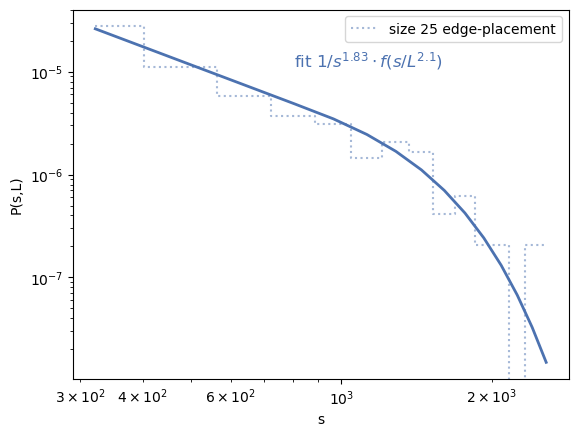

In [423]:
size = 25

# grid, ns, extends =  run(size, 20000, placing='edge')


first_time = np.where(ns/(size*size) > 4)[0][0]

sim = ns[first_time:]

print(len(sim))


hist, edge = np.histogram(sim, bins=16, density=True)

edge = ((edge[1:] + edge[:1])/2)[1:]
hist = hist[1:]

i = 0
x, y = edge, hist

fit_fun = lambda x, tau, d: fit_fun_over(x, tau, Ls[i]**d)

plt.step(x, y,where='mid',color=colors[i],linestyle=':', label=f"size {Ls[i]} edge-placement", alpha = 0.5)

popt, pcov = curve_fit(fit_fun, x, y, p0=[1.5, 2.3])
taus.append(popt[0])
dimensions.append(popt[1])
print(popt[1])

# plt.vlines(Ls[i]**popt[1], 1e-9, 1e-5, color = colors[i])
plt.plot(x, fit_fun(x, *popt), '-', color=colors[i], linewidth=2)

# print text with fit parameters
plt.text(x[3], y[1], "fit $1/s^{"+ f"{popt[0]:.3}" + "}\cdot f(s/L^{"+ f"{popt[1]:.2}" + "})$", color = colors[i], fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.ylabel("P(s,L)")
plt.xlabel("s")
plt.show()
